# Bayes-Faktor für NMR Datensatz - Normalverteilung vs. Student's t-Verteilung

In [6]:
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv("./Daten/chemical_shifts.csv",header=None)
#df = df.iloc[:,0]

az.style.use("arviz-darkgrid")

df.head()

,0
0,51.06
1,55.12
2,53.73
3,50.24
4,52.05


In [8]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sigma=10)
    y = pm.Normal('y', mu=μ, sigma=σ, observed=df)
    trace_g_smc = pm.sample_smc(chains=2)
    
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sigma=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df)
    trace_t_smc = pm.sample_smc(chains=2)

Initializing SMC sampler...
Sampling 2 chains in 2 jobs


We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing SMC sampler...
Sampling 2 chains in 2 jobs


We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [y]


<Axes: xlabel='y'>

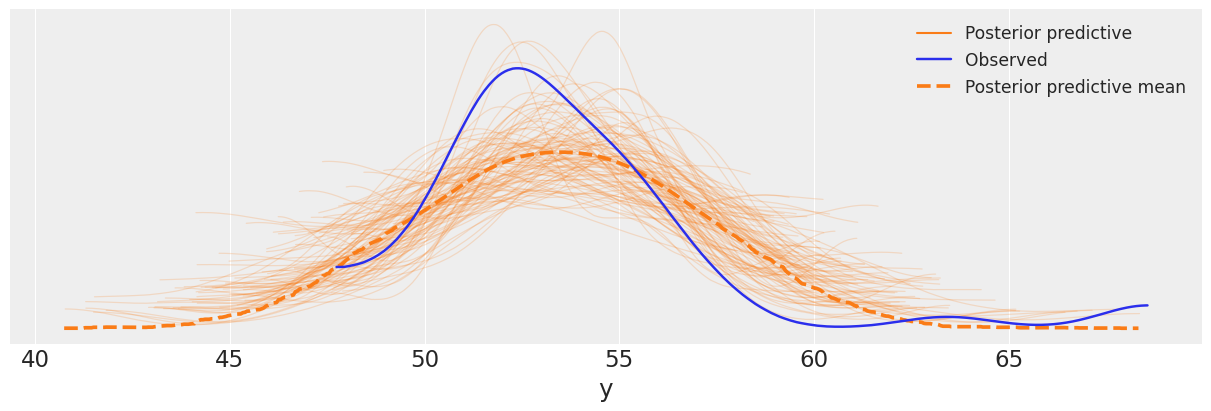

In [9]:
pm.sample_posterior_predictive(trace_g_smc, model=model_g, extend_inferencedata=True, random_seed=123)
az.plot_ppc(trace_g_smc, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Sampling: [y]


<Axes: xlabel='y'>

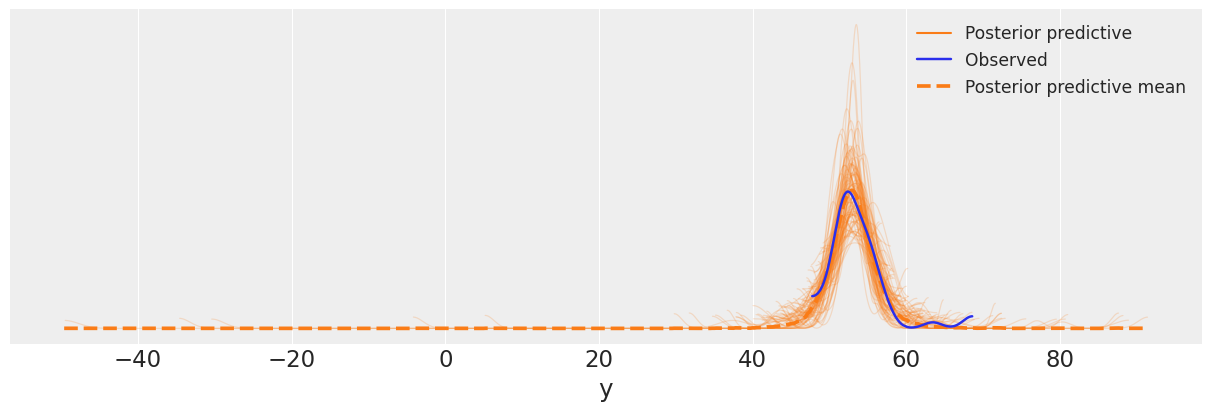

In [10]:
pm.sample_posterior_predictive(trace_t_smc, model=model_t, extend_inferencedata=True, random_seed=123)
az.plot_ppc(trace_t_smc, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Die Verwendung der Student's $t$-Verteilung in unserem Modell führt zu prädiktiven Stichproben, die offensichtlich besser zu den Daten zu passen scheinen, sowohl was die Lage der Spitze der Verteilung als auch was ihre Streuung betrifft.

Man beachte, dass sich die Stichproben weit von der Masse der Daten entfernen und dass einige der prädiktiven Stichproben sehr flach aussehen. Dies ist eine direkte Folge der Student's $t$-Verteilung, die erwartet, dass einzelne Datenpunkte weit vom Mittelwert oder von der Masse der Daten entfernt sind. Die Student's $t$-Verteilung ermöglicht uns eine _robustere Schätzung_, da die Ausreißer den Effekt haben, dass sie $ \nu $ verringern (Verteilung wird flacher), anstatt den Mittelwert in ihre Richtung zu ziehen und die Standardabweichung zu erhöhen. 

## Bayes-Faktor

In [11]:
BF_smc = np.exp(trace_t_smc.sample_stats["log_marginal_likelihood"].mean() - trace_g_smc.sample_stats["log_marginal_likelihood"].mean())
print(np.round(BF_smc.item(),2))

380.48
